A minimal example of colorizing black and white photos, inspired by this [helpful article](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/).

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf
import matplotlib
import numpy as np

from matplotlib import pyplot as plt
from skimage.color import lab2rgb, rgb2lab
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [0]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['axes.grid'] = False

Download and preprocess an image.

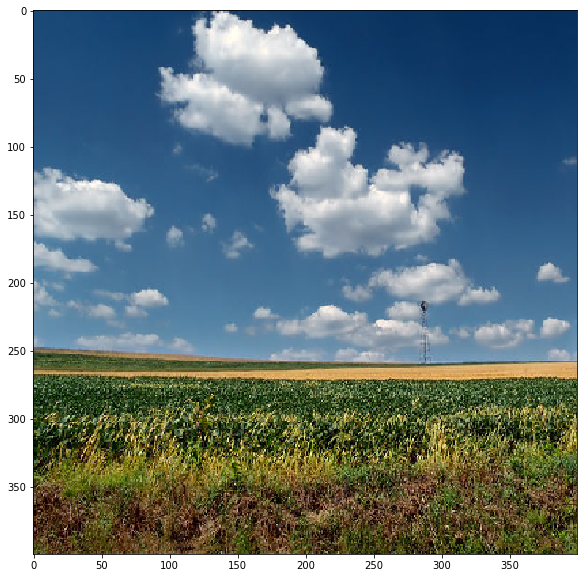

In [4]:
url = 'https://storage.googleapis.com/applied-dl/clouds.jpg'
path = tf.keras.utils.get_file('clouds.jpg', url)

img = load_img(path)
img = img.resize((400,400))
img = img_to_array(img)
img /= 255

plt.imshow(img)

Convert the image to [Lab](https://en.wikipedia.org/wiki/CIELAB_color_space) format. Our X, Y pairs will be the lightness channel (X) and the two color channels (Y).

In [0]:
lab = rgb2lab(img)
X = lab[:,:,0]
Y = lab[:,:,1:]
Y /= 128 # scale to -1, 1

# Create a batch
X = X.reshape(1, 400, 400, 1)
Y = Y.reshape(1, 400, 400, 2)

If you've ever wondered how image colorization can perfectly reproduce the "content" of the image, it's because the first channel encodes most of it! Let's look at just the lightness channel. We'll copy this over to our final output later.

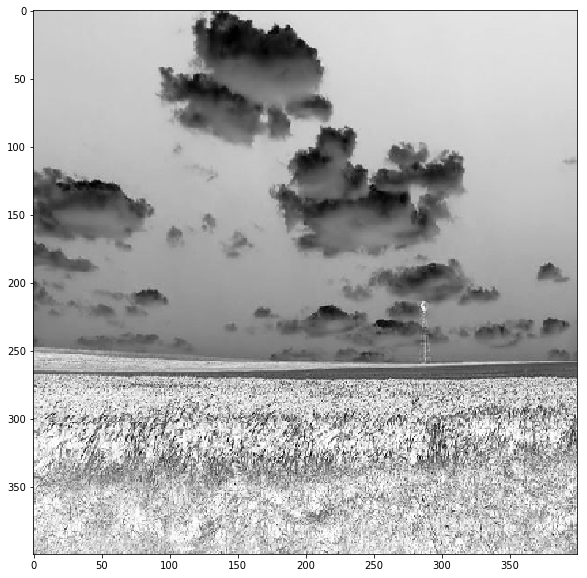

In [6]:
plt.imshow(X[0][:,:,0], cmap='Greys')

Notice the final layer has `tanh` activation. The output will represent the intensity of the two color channels we predict. Later, we'll scale these values by multiplying by 128 to restore them to Lab space.

In [0]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [0]:
model.compile(optimizer='adam', loss='mse')

In [9]:
model.fit(X, Y, batch_size=1, epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/sample - loss: 0.1514
Epoch 2/100
1/1 [==============================] - 0s 20ms/sample - loss: 0.1333
Epoch 3/100
1/1 [==============================] - 0s 19ms/sample - loss: 0.0897
Epoch 4/100
1/1 [==============================] - 0s 13ms/sample - loss: 0.0358
Epoch 5/100
1/1 [==============================] - 0s 14ms/sample - loss: 0.0289
Epoch 6/100
1/1 [==============================] - 0s 14ms/sample - loss: 0.0273
Epoch 7/100
1/1 [==============================] - 0s 11ms/sample - loss: 0.0240
Epoch 8/100
1/1 [==============================] - 0s 13ms/sample - loss: 0.0220
Epoch 9/100
1/1 [==============================] - 0s 11ms/sample - loss: 0.0209
Epoch 10/100
1/1 [==============================] - 0s 12ms/sample - loss: 0.0202
Epoch 11/100
1/1 [==============================] - 0s 11ms/sample - loss: 0.0197
Epoch 12/100
1/1 [==============================] - 0s 13ms/sample - loss: 0.0190
Epoch 13/100
1/1 [=========

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 228 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


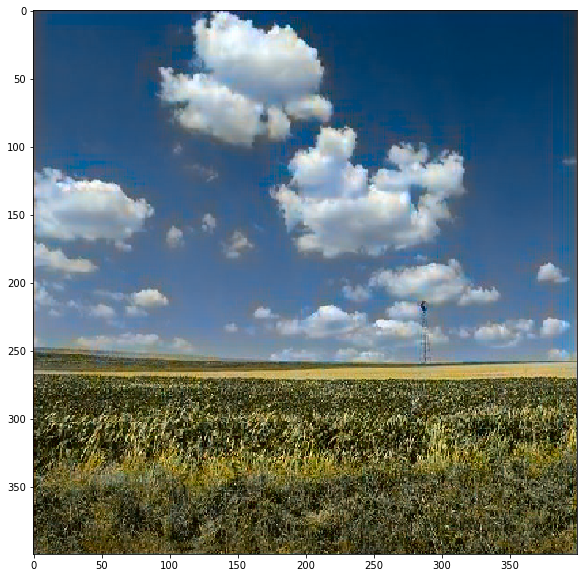

In [10]:
output = model.predict(X)
output *= 128 # scale the output back into Lab

new_image = np.zeros((400, 400, 3)) 
new_image[:,:,0] = X[0][:,:,0] # copy over the first color channel
new_image[:,:,1:] = output[0] # add the two color channels we predicted

rgb = lab2rgb(new_image)

plt.imshow(rgb)